# CS145: Project 3 | Project Name

## Collaborators:
Please list the names and SUNet IDs of your collaborators below:
* *Sumaiya Babar, 2018-CE-229*
* *Asma Eman, 2018-CE-240*


## Project Overview

---

*In this project we have analyzed which factors do play their part on Fare Prediction. For this purpose we are opt to apply one of the machine learning technique i.e. Linear Regression . The coming trip expenditures can be calculated by given factors such as Distance Travelled, trip duration and trip fare. in a scenario the customer pays cash, the tips may not be recorded in the dataset. Thus, we will predict the tips that were payed by cash and have left as zero in the dataset.*

---


## Analysis of Dataset

---

*The dataset for bigquery-public-data.chicago_taxi_trips only contains 1 table - taxi_trips. The table size is 67.71 GB. There are 187,002,005 rows. The table contains information about the pickup and dropoff time and location, the fare amount, tolls, and the total cost of the trip, and the trip duration and total distance traveled as well as different taxi companies.*

----

In [ ]:
# Run this cell to authenticate yourself to BigQuery
from google.colab import auth
auth.authenticate_user()
project_id = "emerald-griffin-321112"

In [ ]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [ ]:
%matplotlib inline
# Add imports for any visualization libraries you may need
import matplotlib.pyplot as plt

In [ ]:
# Run this cell to create a dataset to store your model, or create in the UI

model_dataset_name = 'chicago_taxi_fare'

dataset = bigquery.Dataset(client.dataset(model_dataset_name))
dataset.location = 'US'
client.create_dataset(dataset)

Dataset(DatasetReference('emerald-griffin-321112', 'chicago_taxi_fare'))

## Data Exploration

---

*To make sure that our data is normalized for training, we assume trip distance, trip duration, trip fare and taxi company have finite value by filtering out all rows containing NULL value(s) and removing non-related columns. The following table is a sample of cleaned dataset. We will use this dataset for data exploration and prediction.*

---

In [ ]:
SELECT trip_start_timestamp,
trip_end_timestamp,
trip_seconds,
trip_miles,
fare,
tips,
trip_total,
payment_type,
company,
pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE trip_seconds>0
AND trip_miles>0
AND fare>0
AND trip_total>0
AND payment_type IS NOT NULL
AND company IS NOT NULL
AND pickup_latitude IS NOT NULL
AND pickup_longitude IS NOT NULL
AND dropoff_latitude IS NOT NULL
AND dropoff_longitude IS NOT NULL

In [ ]:
%%bigquery --project $project_id
SELECT *
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
LIMIT 10

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,e5a43898bc158ed36b1e106000bb346f382cf3d5,374daef85c3438787be7fa1399d4a3fc39670fa8b6b946...,2013-05-31 00:45:00+00:00,2013-05-31 00:45:00+00:00,0.0,0.0,None,None,None,None,32.85,5.00,0.0,0.0,37.85,Credit Card,Taxi Affiliation Services,None,None,None,None,None,None
1,614072e4ed5ffa07906bb2f955c276c536cf1886,ecbd0442d6b871f22f17122917c37190e9aaf098687b39...,2013-06-02 02:00:00+00:00,2013-06-02 02:00:00+00:00,180.0,0.0,None,None,None,None,4.65,0.00,0.0,1.0,5.65,Cash,Choice Taxi Association,None,None,None,None,None,None
2,93b79cc43231b49e384fdf9562b44e0995540bad,5e48748b582fe3c16baf5ac371a27773e8aef2927f3344...,2013-05-30 22:45:00+00:00,2013-05-30 22:45:00+00:00,0.0,0.0,None,None,None,None,7.85,1.57,0.0,0.0,9.42,Credit Card,Chicago Elite Cab Corp.,None,None,None,None,None,None
3,f3e0f3546b725eb920cb70101deec1834a158ad6,7f8be35bf085d7490245401fe27b274624245d8e76ae11...,2013-05-31 13:15:00+00:00,2013-05-31 13:15:00+00:00,NaN,0.0,None,None,None,None,7.85,1.57,0.0,0.0,9.42,Credit Card,Chicago Elite Cab Corp.,None,None,None,None,None,None
4,07b34e999c0238794aa692238ae694310b5b9a2a,bc77aa4e4ea60e032d26d6ef6d8e73d49b985a2e7240c4...,2013-05-29 22:15:00+00:00,2013-05-29 22:15:00+00:00,0.0,0.0,None,None,None,None,39.05,7.81,0.0,0.0,46.86,Credit Card,Chicago Elite Cab Corp.,None,None,None,None,None,None
5,1ee13c79df664083f10b5bd9706de56169d33df6,7274daf07dd4da878465e03ee2f72165d7e044bcde1c2c...,2013-05-28 08:45:00+00:00,2013-05-28 08:30:00+00:00,NaN,0.0,None,None,None,None,10.85,1.00,0.0,0.0,11.85,Credit Card,Taxi Affiliation Services,None,None,None,None,None,None
6,b8903d18ddeab9e4d69ca2d9883d072e075ec182,d95b99518116b5f943d75828e78c02e668ec6add7d28ba...,2013-07-20 04:00:00+00:00,2013-07-20 04:15:00+00:00,1200.0,0.0,None,None,None,None,23.65,5.91,0.0,0.0,29.56,No Charge,Chicago Elite Cab Corp.,None,None,None,None,None,None
7,4aeed775970a30fd7da6dadd2550c6612a6ad946,a44086df314a5d983b8f1029ac487a6c6d4bc5341b945f...,2013-05-31 01:00:00+00:00,2013-05-31 01:00:00+00:00,0.0,0.0,None,None,None,None,11.25,2.00,0.0,0.0,13.25,Credit Card,Chicago Elite Cab Corp.,None,None,None,None,None,None
8,f9f0365780ed971fdc5e0958122786027d5a2040,7cda3cbbf6cc9524c807fb5ec5e4ca397f1b736fa2f8a2...,2013-05-30 17:45:00+00:00,2013-05-30 17:45:00+00:00,0.0,0.0,None,None,None,None,14.35,0.00,0.0,0.0,14.35,No Charge,Taxi Affiliation Services,None,None,None,None,None,None
9,f3fdabcbf36a71ddc53d1de1967b2fb613834bc4,7b71bd5b43b70999e3c9e047b26bdb5d01cd3ed9362c3b...,2013-05-30 19:15:00+00:00,2013-05-30 19:15:00+00:00,60.0,0.0,None,None,None,None,3.25,0.00,0.0,6.5,9.75,No Charge,Dispatch Taxi Affiliation,None,None,None,None,None,None


In [ ]:
%%bigquery --project $project_id miles_tips
SELECT DISTINCT trip_miles, tips
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE tips>0

Text(0.5, 1.0, 'Trip miles vs Tips')

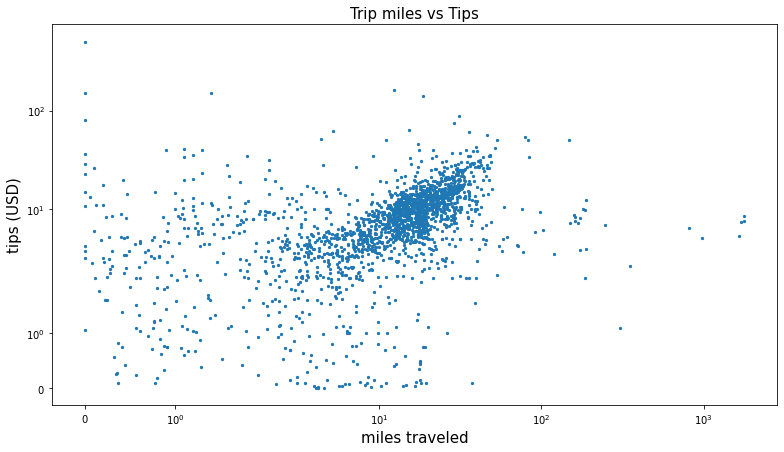

In [ ]:
miles_tips_sub = miles_tips.sample(2000)
plt.figure(figsize=(13, 7))
plt.scatter(miles_tips_sub["trip_miles"], miles_tips_sub["tips"], s=5)
plt.yscale('symlog')
plt.xscale('symlog')
plt.xlabel('miles traveled', fontsize=15)
plt.ylabel('tips (USD)', fontsize=15)
plt.title('Trip miles vs Tips', fontsize=15)

In [ ]:
%%bigquery --project $project_id seconds_tips
SELECT DISTINCT trip_seconds, tips
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE tips>0

Text(0.5, 1.0, 'Trip duration vs Tips')

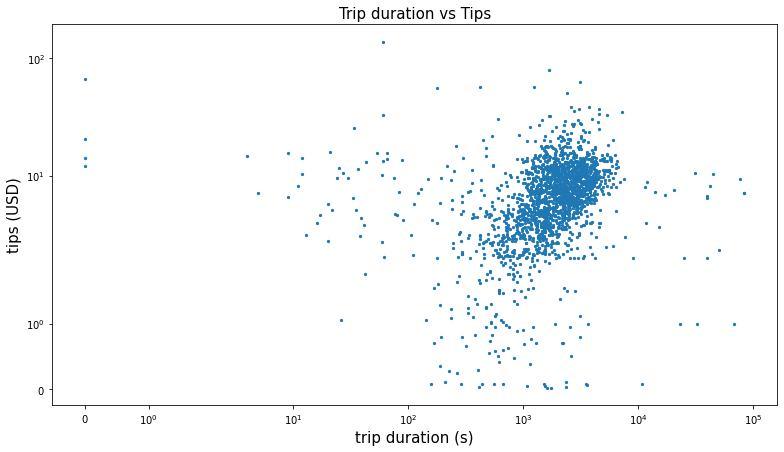

In [ ]:
seconds_tips_sub = seconds_tips.sample(2000)
plt.figure(figsize=(13, 7))
plt.scatter(seconds_tips_sub["trip_seconds"], seconds_tips_sub["tips"], s=5)
plt.yscale('symlog')
plt.xscale('symlog')
plt.xlabel('trip duration (s)', fontsize=15)
plt.ylabel('tips (USD)', fontsize=15)
plt.title('Trip duration vs Tips', fontsize=15)

In [ ]:
%%bigquery --project $project_id fare_tips
SELECT DISTINCT fare, tips
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE tips>0

Text(0.5, 1.0, 'Trip fare vs Tips')

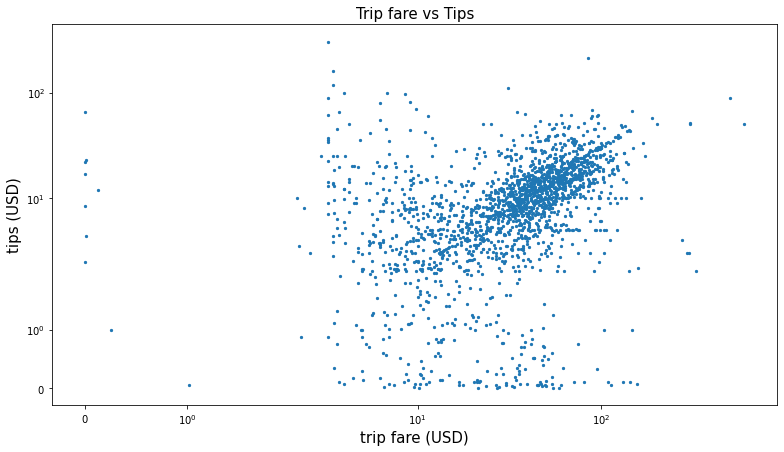

In [ ]:
fare_tips_sub = fare_tips.sample(2000)
plt.figure(figsize=(13, 7))
plt.scatter(fare_tips_sub["fare"], fare_tips_sub["tips"], s=5)
plt.yscale('symlog')
plt.xscale('symlog')
plt.xlabel('trip fare (USD)', fontsize=15)
plt.ylabel('tips (USD)', fontsize=15)
plt.title('Trip fare vs Tips', fontsize=15)

In [ ]:
%%bigquery --project $project_id
SELECT company, COUNT(*) count, AVG(tips) avg_tips
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE tips>0 AND trip_miles>0 AND company IS NOT NULL
GROUP BY company
ORDER BY count DESC
LIMIT 10

,company,count,avg_tips
0,Taxi Affiliation Services,9669788,3.820970
1,Flash Cab,6214400,3.539800
2,Yellow Cab,3877946,3.198646
3,Chicago Carriage Cab Corp,3537433,3.922769
4,Dispatch Taxi Affiliation,3079220,3.378661
5,Choice Taxi Association,2882806,3.753596
6,Sun Taxi,2471739,4.103353
7,City Service,2439335,3.932554
8,Medallion Leasin,2071039,3.954155
9,Taxi Affiliation Service Yellow,1513190,3.958902


**So our first question to be answered was which company will get more previliges and on what basis ?**

*The answere to above question is that the company will receive more incentive and previligeson the terms of tips , means the more tips a company gets on average the more it will prosper in future as tips is depending on satisfaction of the rider.*


In [ ]:
%%bigquery --project $project_id miles_tips_yc
SELECT DISTINCT trip_miles, tips
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE tips>0 AND company LIKE 'Yellow Cab'

Text(0.5, 1.0, 'Trip miles vs Tips for Yellow Cab')

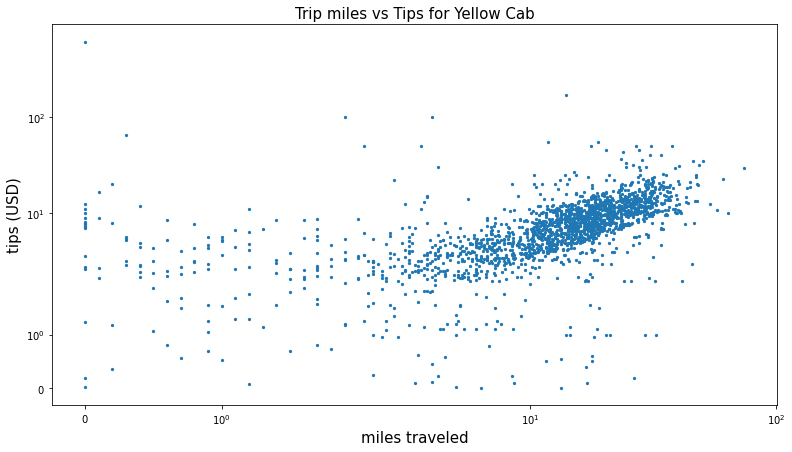

In [ ]:
miles_tips_yc_sub = miles_tips_yc.sample(2000)
plt.figure(figsize=(13, 7))
plt.scatter(miles_tips_yc_sub["trip_miles"], miles_tips_yc_sub["tips"], s=5)
plt.yscale('symlog')
plt.xscale('symlog')
plt.xlabel('miles traveled', fontsize=15)
plt.ylabel('tips (USD)', fontsize=15)
plt.title('Trip miles vs Tips for Yellow Cab', fontsize=15)

In [ ]:
%%bigquery --project $project_id seconds_tips_yc
SELECT DISTINCT trip_seconds, tips
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE tips>0 AND company LIKE 'Yellow Cab'

Text(0.5, 1.0, 'Trip duration vs Tips for Yellow Cab')

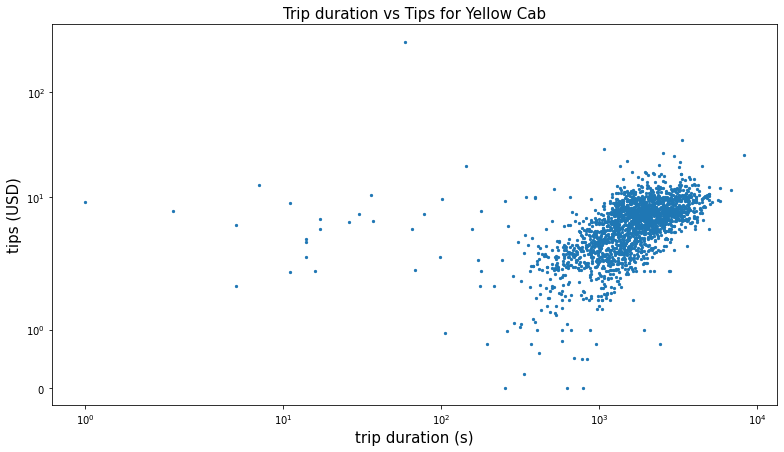

In [ ]:
seconds_tips_yc_sub = seconds_tips_yc.sample(2000)
plt.figure(figsize=(13, 7))
plt.scatter(seconds_tips_yc_sub["trip_seconds"], seconds_tips_yc_sub["tips"], s=5)
plt.yscale('symlog')
plt.xscale('symlog')
plt.xlabel('trip duration (s)', fontsize=15)
plt.ylabel('tips (USD)', fontsize=15)
plt.title('Trip duration vs Tips for Yellow Cab', fontsize=15)

In [ ]:
%%bigquery --project $project_id fare_tips_yc
SELECT DISTINCT fare, tips
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE tips>0 AND company LIKE 'Yellow Cab'

Text(0.5, 1.0, 'Trip fare vs Tips for Yellow Cab')

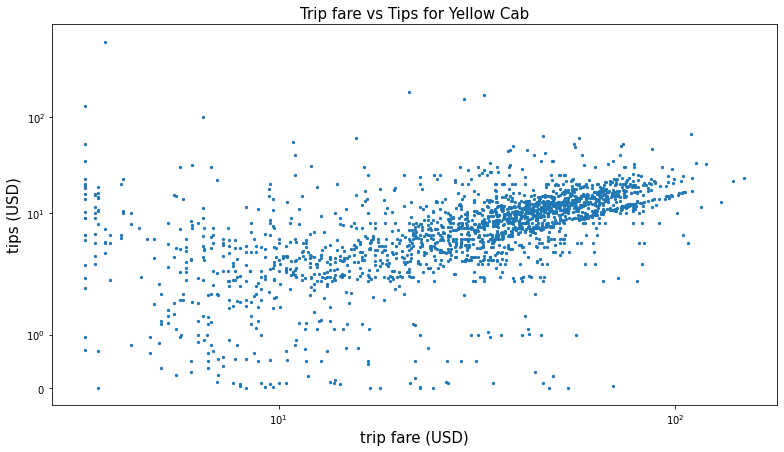

In [ ]:
fare_tips_yc_sub = fare_tips_yc.sample(2000)
plt.figure(figsize=(13, 7))
plt.scatter(fare_tips_yc_sub["fare"], fare_tips_yc_sub["tips"], s=5)
plt.yscale('symlog')
plt.xscale('symlog')
plt.xlabel('trip fare (USD)', fontsize=15)
plt.ylabel('tips (USD)', fontsize=15)
plt.title('Trip fare vs Tips for Yellow Cab', fontsize=15)

## Data Prediction

---

*AS mentioned earlier we will use only non zero value of tips to refrain from any anomalies in training our models. We will split data 
Training: trip start time < 2016-01-01
Validation: trip start time between 2016-01-01 and 2017-01-01
Test: trip start time between 2017-01-01 and 2018-01-01

*Note that since from the above visualization, we found the linear relation between distance, duration, fare and tips is in log-log scale; therefore,
we take the log of both feature and label to make sure they also exhibit the linear relation.*

---

In [ ]:
%%bigquery --project $project_id
CREATE OR REPLACE MODEL `chicago_taxi_fare.chicago_taxi_tips_model_v1`
OPTIONS(model_type='linear_reg') AS
SELECT DISTINCT
LOG(tips+1) AS label,
LOG(trip_miles+1) AS feature1
FROM
`bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
trip_start_timestamp < '2016-01-01' AND tips>0

""


In [ ]:
%%bigquery --project $project_id
SELECT
*
FROM
ML.TRAINING_INFO(MODEL `chicago_taxi_fare.chicago_taxi_tips_model_v1`)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,0.438542,0.435014,None,5764


In [ ]:
%%bigquery --project $project_id
# YOUR QUERY HERE
SELECT
*
FROM
ML.EVALUATE(MODEL `chicago_taxi_fare.chicago_taxi_tips_model_v1`, (
SELECT DISTINCT
LOG(tips+1) AS label,
LOG(trip_miles+1) AS feature1
FROM
`bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
trip_start_timestamp BETWEEN '2016-01-01' AND '2017-01-01' AND tips>0))

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,0.449509,0.36731,0.05036,0.347039,0.167142,0.170534


In [ ]:
%%bigquery --project $project_id
CREATE OR REPLACE MODEL `chicago_taxi_fare.chicago_taxi_tips_model_v2`
OPTIONS(model_type='linear_reg') AS
SELECT DISTINCT
LOG(tips+1) AS label,
LOG(trip_seconds+1) AS feature1
FROM
`bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
trip_start_timestamp < '2016-01-01' AND tips>0

""


In [ ]:
%%bigquery --project $project_id
SELECT
*
FROM
ML.TRAINING_INFO(MODEL `chicago_taxi_fare.chicago_taxi_tips_model_v2`)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,0.309395,0.301619,None,9027


In [ ]:
%%bigquery --project $project_id
# YOUR QUERY HERE
SELECT
*
FROM
ML.EVALUATE(MODEL `chicago_taxi_fare.chicago_taxi_tips_model_v2`, (
SELECT DISTINCT
LOG(tips+1) AS label,
LOG(trip_seconds+1) AS feature1
FROM
`bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
trip_start_timestamp BETWEEN '2016-01-01' AND '2017-01-01' AND tips>0))

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,0.423385,0.29236,0.039235,0.369822,0.065059,0.093838


In [ ]:
%%bigquery --project $project_id
CREATE OR REPLACE MODEL `chicago_taxi.chicago_taxi_tips_model_v3`
OPTIONS(model_type='linear_reg') AS
SELECT DISTINCT
LOG(tips+1) AS label,
LOG(trip_seconds+1) AS feature1,
LOG(trip_miles+1) AS feature2
FROM
`bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
trip_start_timestamp < '2016-01-01' AND tips>0

""


In [ ]:
%%bigquery --project $project_id
SELECT
*
FROM
ML.TRAINING_INFO(MODEL `chicago_taxi.chicago_taxi_tips_model_v3`)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,0.224457,0.220545,None,24470


In [ ]:
%%bigquery --project $project_id
# YOUR QUERY HERE
SELECT *
FROM
ML.EVALUATE(MODEL `chicago_taxi.chicago_taxi_tips_model_v3`, (
SELECT DISTINCT
LOG(tips+1) AS label,
LOG(trip_seconds+1) AS feature1,
LOG(trip_miles+1) AS feature2
FROM
`bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
trip_start_timestamp BETWEEN '2016-01-01' AND '2017-01-01' AND tips>0))

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,0.329475,0.195173,0.030569,0.27248,0.415901,0.420677


In [ ]:
%%bigquery --project $project_id
CREATE OR REPLACE MODEL `chicago_taxi_fare.chicago_taxi_tips_model_v4`
OPTIONS(model_type='linear_reg') AS
SELECT DISTINCT
LOG(tips+1) AS label,
LOG(trip_seconds+1) AS feature1,
LOG(trip_miles+1) AS feature2,
LOG(fare+1) AS feature3
FROM
`bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
trip_start_timestamp < '2016-01-01' AND tips>0

""


In [ ]:
%%bigquery --project $project_id
SELECT
*
FROM
ML.TRAINING_INFO(MODEL `chicago_taxi_fare.chicago_taxi_tips_model_v4`)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,0.150985,0.146353,None,17407


In [ ]:
%%bigquery --project $project_id
# YOUR QUERY HERE
SELECT
*
FROM
ML.EVALUATE(MODEL `chicago_taxi_fare.chicago_taxi_tips_model_v4`, (
SELECT DISTINCT
LOG(tips+1) AS label,
LOG(trip_seconds+1) AS feature1,
LOG(trip_miles+1) AS feature2,
LOG(fare+1) AS feature3
FROM
`bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
trip_start_timestamp BETWEEN '2016-01-01' AND '2017-01-01' AND tips>0))

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,0.299485,0.273187,0.096073,0.173852,0.201932,0.212272


In [ ]:
%%bigquery --project $project_id
# YOUR QUERY HERE
SELECT
*
FROM
 ML.PREDICT(MODEL `chicago_taxi_fare.chicago_taxi_tips_model_v2`, (
SELECT DISTINCT
LOG(trip_seconds+1) AS feature1,
LOG(trip_miles+1) AS feature2,
LOG(fare+1) AS feature3
FROM
 `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
 trip_start_timestamp BETWEEN '2017-01-01' AND '2018-01-01' AND tips=0.0 AND company LIKE 'Yellow Cab' AND payment_type LIKE 'Cash'
LIMIT 10)) 

,predicted_label,feature1,feature2,feature3
0,1.818325,6.968850,0.693147,2.351375
1,1.618514,5.389072,0.530628,1.832581
2,1.848649,7.208600,2.186051,3.188417
3,1.780463,6.669498,1.435085,2.583998
4,1.774884,6.625392,1.163151,2.397895
5,1.642628,5.579730,0.530628,1.871802
6,1.763482,6.535241,1.945910,2.917771
7,1.703557,6.061457,0.993252,2.169054
8,1.747455,6.408529,1.386294,2.442347
9,1.683469,5.902633,0.993252,2.110213


these are the  predictions for the tips payed by cash of the trips offered by Yellow Cab. 

## Conclusion

---

* Only that company will receive more incentive and previliges on the terms of tips , means the more tips a company gets on average the more it will prosper in future as tips is depending on satisfaction of the rider i.eTaxi Affiliation Services
* From the above exploration, we found that the tips of a taxi trip are correlated to traveling distance, duration and fare. We also make the predictions for the tips which are missing in the data.

---